# Climate modes and diagnostics

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:30:00'
cores = 10
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43431 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/43431/status,
Dashboard: /proxy/43431/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.17:42703,Workers: 0
Dashboard: /proxy/43431/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# import warnings

import xarray as xr
import numpy as np

from xbootstrap import block_bootstrap

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

import string
letters = list(string.ascii_lowercase)

In [7]:
%cd /g/data/w42/dr6273/work/AEMO_compound_events/

import functions as fn

/g/data/w42/dr6273/work/AEMO_compound_events


In [8]:
plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [9]:
plt_params

{'lines.linewidth': 1.3,
 'hatch.linewidth': 0.5,
 'font.size': 7,
 'legend.fontsize': 6,
 'legend.columnspacing': 0.7,
 'legend.labelspacing': 0.03,
 'legend.handlelength': 1.0,
 'axes.linewidth': 0.5,
 'axes.titlesize': 8}

In [10]:
years = range(1959, 2022)

data_fp = '/g/data/w42/dr6273/work/data/'

season_dict = fn.get_seasons()

# Load masks

In [11]:
rez_mask = fn.get_rez_mask()

# Load energy source and demand data

Sources: daily wind, daily solar and monthly runoff

In [12]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w']#.compute()

In [13]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd']#.compute()

Aus - gridded

In [14]:
aus_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100w/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['w100']

In [15]:
aus_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/msdwswrf/msdwswrf_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_AUS_region.zarr',
    consolidated=True
)['msdwswrf']

Thresholds for event definitions

In [16]:
thresh_100w = rez_100w.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #4 # Close to all region-time 25th percentile of 4.19
thresh_mssrd = rez_mssrd.chunk({'time': -1}).quantile(0.25, ['time', 'region']) #170 # All region-time 25th percentile is 132.7

### Events

In [17]:
events_100w = fn.get_events(rez_100w, thresh_100w, tail='lower').compute()

In [18]:
events_mssrd = fn.get_events(rez_mssrd, thresh_mssrd, tail='lower').compute()

In [19]:
events_100w_mssrd = fn.get_compound_events(rez_100w, rez_mssrd, thresh_100w, thresh_mssrd).compute()

### Daily events over all regions

In [20]:
simul_100w = fn.concurrent_lulls(events_100w, [1, 3, 5, 7], rez_mask)
simul_mssrd = fn.concurrent_lulls(events_mssrd, [2, 3, 6, 7], rez_mask)
simul_100w_mssrd = fn.concurrent_lulls(events_100w_mssrd, [3, 7], rez_mask)

### Seasonal events over all regions

In [21]:
season_100w = fn.seasonal_mean(simul_100w)
season_mssrd = fn.seasonal_mean(simul_mssrd)
season_100w_mssrd = fn.seasonal_mean(simul_100w_mssrd)

# Load diagnostics and climate mode indices

### Daily diagnostics

500 hPa geopotential height

In [22]:
daily_z500_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/z/z_anoms_era5_daily_1400UTC_pl_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['z'].squeeze()

MSLP

In [23]:
daily_mslp = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

In [24]:
daily_mslp_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/mslp/mslp_anoms_era5_daily_1400UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['mslp']

100u and 100v

In [25]:
daily_u100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100u/100u_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['u100']

In [26]:
daily_v100 = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/100v/100v_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['v100']

Tcc

In [27]:
daily_tcc = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [28]:
daily_tcc_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/tcc/tcc_anoms_era5_12hr_2000-0800UTC_'+str(years[0])+'-'+str(years[-1])+'_extended_Aus_region.zarr',
    consolidated=True
)['tcc']

In [29]:
# TCC has 0800UTC time. Re-assign to 1400UTC to match other variables
daily_tcc = daily_tcc.assign_coords({'time': daily_u100.time})

In [30]:
daily_tcc_anoms = daily_tcc_anoms.assign_coords({'time': daily_u100.time})

2m T

In [31]:
daily_2t = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

In [32]:
daily_2t_anoms = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/era5/2t/2t_anoms_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_extended_AUS_region.zarr',
    consolidated=True
)['t2m']

### Monthly diagnostics and seasonal means

HadISST SST anomalies

In [33]:
sst_fp = data_fp + 'hadisst/sst/sst_anom_hadisst_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sst_anoms = xr.open_zarr(sst_fp, consolidated=True)
sst_anoms = fn.seasonal_mean(sst_anoms)

ERA5 MSLP anomalies

In [34]:
mslp_fp = data_fp + 'era5/mslp/mslp_anom_era5_moda_sfc_'+str(years[0])+'-'+str(years[-1])+'.zarr'
mslp_anoms = xr.open_zarr(mslp_fp, consolidated=True)
mslp_anoms = fn.seasonal_mean(mslp_anoms)

### Climate mode indices

Nino3.4

In [22]:
nino34_fp = data_fp + 'hadisst/climate_modes/hadisst_nino34_'+str(years[0])+'-'+str(years[-1])+'.zarr'
nino34 = xr.open_zarr(nino34_fp, consolidated=True)
nino34 = fn.seasonal_mean(nino34)
nino34 = nino34.compute()

DMI

In [23]:
dmi_fp = data_fp + 'hadisst/climate_modes/hadisst_dmi_'+str(years[0])+'-'+str(years[-1])+'.zarr'
dmi = xr.open_zarr(dmi_fp, consolidated=True)
dmi = fn.seasonal_mean(dmi)
dmi = dmi.compute()

SAM

In [24]:
sam_fp = data_fp + 'era5/climate_modes/era5_sam_'+str(years[0])+'-'+str(years[-1])+'.zarr'
sam = xr.open_zarr(sam_fp, consolidated=True)
sam = fn.seasonal_mean(sam)
sam = sam.compute()

# Daily diagnostics on spatially extensive wind/solar/compound drought days

In [25]:
def get_spatial_events(da, season, q, time_name='time'):
    """
    Subsample the time steps which are spatially compounding,
    defined as when the number of regions experiencing an event
    exceeds a quantile threshold (q). Can be done by season.
    """
    months = fn.get_seasons()[season] # months in this season
    subset_da = fn.month_subset(da, months, time_name) # select data in this season
    thresh = subset_da.quantile(q, time_name) # top q extensive events
    events = subset_da.where(subset_da > thresh)
    n_events = events.count().values # number of events
    years = events.dropna(time_name)[time_name].dt.year.values # Years that events occurred in
    
    return years, events, n_events

In [26]:
def subset_on_events(event_da, diag_da, season, q, time_name='time'):
    """
    Obtain the diagnostic variable array over event years.
    """
    years, events, n_events = get_spatial_events(event_da, season, q, time_name)
    diag = fn.month_subset(diag_da, fn.get_seasons()[season])
    diag = diag.where(events.notnull())
    return years, events, n_events, diag

In [27]:
def composite_data(event_da, diag_da, season, q, time_name='time'):
    """
    Composite (average) the diagnostic array over event years.
    """
    years, events, n_events, diag = subset_on_events(event_da, diag_da, season, q, time_name)
    return years, n_events, diag.mean(time_name)

In [28]:
def get_plot_data(events_dict, diag1, diag2, diag1_name, diag2_name, thresh):
    """
    Compute the data needed for plotting and save to a dictionary.
    We do this so we can tweak the figure without needed to process
    the data each time.
    
    events_dict: dictionary with events for each energy type
    diag1, diag2: dataarrays of diagnostic variables
    diag1_name, diag2_name: str. names of diag vars for dict.
    thresh: threshold used to define 'spatially extensive' events.
    """
    plot_dict = {}
    for season in list(season_dict.keys())[1:]:
        
        plot_dict[season] = {}
        
        for name, var in zip(events_dict.keys(), events_dict.values()):
            plot_dict[season][name] = {}
            
            years, n_events, p_1 = composite_data(
                var,
                diag1,
                season,
                thresh
            )

            _, _, p_2 = composite_data(
                var,
                diag2,
                season,
                thresh
            )
            
            plot_dict[season][name][diag1_name] = p_1.compute()
            plot_dict[season][name][diag2_name] = p_2.compute()
            plot_dict[season][name]['n_events'] = n_events
            
    return plot_dict

In [29]:
def region_data(simul_da, event_da, region_codes, season, thresh):
    """
    Get data of each region's frequency of occurrence
    in spatially extensive event days.
    
    simul_da: simultaneous events i.e. total number of daily events
                across all regions
    event_da: events by region
    region_codes: regions of interest e.g. wind only, wind and solar
    """
    _, events, _ = get_spatial_events(simul_da, season, thresh) # Spatialy extensive events
    # Subset event_da for regions of interest
    event_da = event_da.sel(region=fn.get_regions_from_region_codes(region_codes, rez_mask))
    # Compute average events by region over time
    averages = event_da.where(events.notnull()).mean('time')
    # Sort by frequency
    sort_avg = averages.sortby(averages, ascending=False)
    
    # Colors to plot each region with
    sort_colors = []
    for r in sort_avg.region.values:
        sort_colors.append(region_colors[r[0]])
        
    return {'data': sort_avg, 'colors': sort_colors}

In [43]:
region_colors = {
    'N': plt.cm.tab10(8),
    'O': plt.cm.tab10(0),
    'Q': plt.cm.tab10(9),
    'S': plt.cm.tab10(6),
    'T': plt.cm.tab10(2),
    'V': plt.cm.tab10(1)
}

In [44]:
thresh_spatial = 0.95 # top 5 % spatially extensive days

In [44]:
# Dictionary of daily events by region, with 
#. corresponding region codes
daily_events_dict = {
    'Solar': {
        'data': events_mssrd,
        'codes': [2, 3, 6, 7]
    },
    'Wind': {
        'data': events_100w,
        'codes': [1, 3, 5, 7]
    },
    'Compound': {
        'data': events_100w_mssrd,
        'codes': [3, 7]
    }
}

In [45]:
# Dictionary of droughts across all regions
daily_simul_dict = {
    'Solar': simul_mssrd,
    'Wind': simul_100w,
    'Compound': simul_100w_mssrd
}

In [46]:
# Plotting data - Z500 and MSLP
daily_plot_dict = get_plot_data(
    daily_simul_dict,
    daily_z500_anoms,
    daily_mslp,
    'z',
    'mslp',
    thresh_spatial
)

In [45]:
def get_frequency_text(simul_dict, thresh):
    """
    Get the text for each subplot. Text is the number of event
    days, and percentages of solar/wind events in compound events.
    """
    n_event_text = np.full((4, 3), 'xxx', dtype='object')
    for i, season in enumerate(list(season_dict.keys())[1:]):
        _, solar_events, n_solar = get_spatial_events(simul_dict['Solar'], season, thresh)
        _, wind_events, n_wind = get_spatial_events(simul_dict['Wind'], season, thresh)
        _, compound_events, n_compound = get_spatial_events(simul_dict['Compound'], season, thresh)
        
        solar_in_compound = xr.where(
            (solar_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        wind_in_compound = xr.where(
            (wind_events.notnull()) &
            (compound_events.notnull()),
            1,
            0).sum().values
        
        pc_solar = np.round((solar_in_compound / n_compound) * 100, 1)
        pc_wind = np.round((wind_in_compound / n_compound) * 100, 1)
        
        n_event_text[i, 0] = str(n_solar) + ' (' + str(pc_solar) + '%)'
        n_event_text[i, 1] = str(n_wind) + ' (' + str(pc_wind) + '%)'
        n_event_text[i, 2] = str(n_compound)
        
    return n_event_text

In [48]:
def plot_z_mslp(ax1, ax2, z_da, mslp_da, region_dict, text=None, mslp_anoms=False):
    """
    Plot geopotential height shading and MSLP contours on an axis.
    MSLP can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot
    # print(z_da.min().values, z_da.max().values)
    # print(mslp_da.min().values, mslp_da.max().values)
    # print()
    
    if mslp_anoms:
        m = 1000
        mslp_levels = np.arange(-m, m+1, 100)
        mslp_levels = [i for i in mslp_levels if i != 0]
    else:
        mslp_levels = np.arange(97000, 106000, 500)
    
    # ax1.coastlines(linewidths=0.1)
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    # ax1.set_extent([112, 155, -10, -45])
    
    p = z_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=-70,
        vmax=70,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    mslp_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.4
    )
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    x = region_dict['data'].values
    y = region_dict['data'].region.values
    ax2.barh(y, x, color=region_dict['colors'], height=.8)
    
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0,1.])
    ax2.set_xticklabels('')
    
    ax2.set_ylim(-0.5, len(y))
    ax2.set_yticks([])
    
    for pos in ['top', 'right']:
        ax2.spines[pos].set_visible(False)
    
    return p

In [50]:
def plot_synoptics(plot_dict, cbar_label, cbar_ticks, cbar_extend, uv_plot_dict=None, anoms=False, save_fig=False):
    """
    Plot synoptic maps with side bar plots showing which regions feature
    in spatially extensive composites.
    
    plot_dict: dictionary containing data for plotting on map
    uv_plot_dict: disctionary containing u and v data for quiver plot
    cbar_label: colorbar label for da1
    cbar_ticks: ticks for colorbar
    cbar_extend: extend mode for colorbar
    anoms: Bool. Whether second variable is anomalies or not.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(figsize=(6.9, 5.1)) 

        n_event_text = get_frequency_text(daily_simul_dict, thresh_spatial)
        
        da1_name = list(plot_dict['Winter']['Solar'].keys())[0]
        da2_name = list(plot_dict['Winter']['Solar'].keys())[1]

        axes = []

        count = 0
        for i, season in enumerate(list(season_dict.keys())[1:]):
            for j, (name, var) in enumerate(zip(daily_simul_dict.keys(), daily_simul_dict.values())):
                # Get map data
                p1 = plot_dict[season][name][da1_name]
                p2 = plot_dict[season][name][da2_name]
                
                # Get region data for bar plot
                p_region = region_data(
                    daily_simul_dict[name],
                    daily_events_dict[name]['data'],
                    daily_events_dict[name]['codes'],
                    season,
                    thresh_spatial
                )
                
                # Dynamically program axes positions
                bottom1 = 0.75 - 0.25 * i
                top1 = 1 - 0.25 * i

                bottom2 = 0.76 - 0.25 * i
                top2 = 0.99 - 0.25 * i

                left1 = 0 + 0.33 * j
                right1 = 0.2 + 0.33 * j

                left2 = 0.21 + 0.33 * j
                right2 = 0.3 + 0.33 * j

                # Set up axes
                gs1 = fig.add_gridspec(nrows=1, ncols=1, left=left1, right=right1, bottom=bottom1, top=top1)
                gs2 = fig.add_gridspec(nrows=1, ncols=1, left=left2, right=right2, bottom=bottom2, top=top2)

                ax1 = plt.subplot(gs1[0], projection=ccrs.PlateCarree())
                ax2 = plt.subplot(gs2[0])
                axes.append([ax1, ax2])

                # Plot
                if uv_plot_dict is None:
                    p = plot_z_mslp(ax1, ax2, p1, p2, p_region,
                                    text='(' + letters[count] + ') ' + n_event_text[i, j], mslp_anoms=anoms)
                else:
                    u = uv_plot_dict[season][name]['u']
                    v = uv_plot_dict[season][name]['v']
                    p, p_w = plot_wind_tcc_t(ax1, ax2, p1, u, v, p2, p_region,
                                             text='(' + letters[count] + ') ' + n_event_text[i, j], tcc_anoms=anoms)
                    
                count += 1

        plt.subplots_adjust(hspace=0., wspace=0.0)

        # Labels and titles
        axes[0][0].text(0.5, 1.05, 'Solar', ha='center', transform=axes[0][0].transAxes)
        axes[1][0].text(0.5, 1.05, 'Wind', ha='center', transform=axes[1][0].transAxes)
        axes[2][0].text(0.5, 1.05, 'Compound', ha='center', transform=axes[2][0].transAxes)

        axes[0][0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0][0].transAxes)
        axes[3][0].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3][0].transAxes)
        axes[6][0].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6][0].transAxes)
        axes[9][0].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9][0].transAxes)

        # Colorbar
        cb_ax1 = fig.add_axes([0.1, -0.1, 0.36, 0.02])
        cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=cbar_ticks, extend=cbar_extend)
        cb1.ax.set_xlabel(cbar_label)

        # Barplot legend
        labels = ['NSW', 'Offshore', 'QLD', 'SA', 'TAS', 'VIC']
        handles = [plt.Rectangle((0,0),1,1, color=i) for i in region_colors.values()]
        axes[-1][1].legend(handles, labels, ncols=6, loc=(-4, -.5), frameon=False)

        # Barplot xticks and labels
        for i in [-3, -2, -1]:
            axes[i][1].set_xticklabels([0, 1])
            axes[i][1].set_xlabel('Relative freq. [-]')
            
        # Quiver legend
        if uv_plot_dict is None:
            pass
        else:
            qk = axes[9][0].quiverkey(p_w, -3.1, -0.4, 10, label=r'10 ms$^{-1}$', labelpos='N', labelcolor='k')
            
        if save_fig:
            plt.savefig('./figures/FigX_circulation.pdf', format='pdf', dpi=400, bbox_inches='tight')

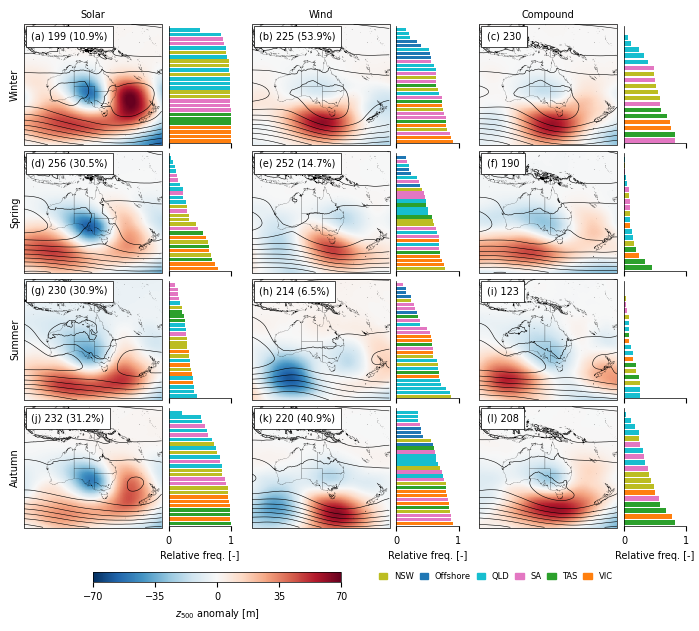

In [52]:
plot_synoptics(
    daily_plot_dict,
    r'$z_{500}$ anomaly [m]',
    np.arange(-70, 71, 35),
    'neither',
    save_fig=True
)

In [58]:
# Plotting data - Wind speed/direction (u and v)
daily_plot_u_v = get_plot_data(
    daily_simul_dict,
    daily_u100,
    daily_v100,
    'u',
    'v',
    thresh_spatial
)

In [59]:
# Plotting data - tcc anoms and T anoms
daily_plot_tcc_t2m_anoms = get_plot_data(
    daily_simul_dict,
    daily_tcc_anoms,
    daily_2t_anoms,
    'tcc_anoms',
    '2t_anoms',
    thresh_spatial
)

In [65]:
daily_plot_tcc_t2m_anoms['Winter']['Solar']['tcc_anoms'].max()

<xarray.DataArray 'tcc' ()>
array(0.55217481)
Coordinates:
    quantile  float64 0.25

In [57]:
def plot_wind_tcc_t(ax1, ax2, tcc_da, u_da, v_da, t_da, region_dict, text=None, tcc_anoms=False):
    """
    Plot total cloud cover shading, wind direction/speed arrows and
    temperature anomalies as contours on an axis.
    TCC can be either full field or anomalies.
    
    Bar plot of regions' tendency to be part of spatially
    extensive days.
    """
    ### =========== Diagnostics subplot     
    if tcc_anoms:
        # m = 1
        # tcc_levels = np.arange(-m, m+1, 0.1)
        # tcc_levels = [i for i in mslp_levels if i != 0]
        tcc_vmin = -0.3
        tcc_vmax = 0.3
    else:
        # mslp_levels = np.arange(0, 1, 0.1)
        tcc_vmin = 0
        tcc_vmax = 1
    
    ax1.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax1.coastlines(lw=.3, rasterized=True)
    ax1.set_extent([105, 170, 0, -50], crs=ccrs.PlateCarree())
    
    # ===== TCC shading
    p = tcc_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        vmin=tcc_vmin,
        vmax=tcc_vmax,
        cmap='PuOr',
        add_colorbar=False,
        rasterized=True
    )
    
    # ====== Wind Quiver plot
    step = 20
    p_w = ax1.quiver(
        u_da.lon.values[::step],
        u_da.lat.values[::step],
        u_da.values[::step,::step],
        v_da.values[::step,::step],
        angles='xy',
        scale=2,
        scale_units='xy',
        width=0.005,
        # headwidth=8,
        transform=ccrs.PlateCarree(),
        # rasterized=True
    )
    
    # ====== Temperature anomaly contours
    m = 20
    levels = np.arange(-m, m+1, 1)
    levels = [i for i in levels if i != 0]
    p_t = t_da.plot.contour(
        ax=ax1,
        levels=levels,
        colors=colors[3],
        transform=ccrs.PlateCarree(),
        linewidths=.5
    )
    try:
        ax1.clabel(p_t, np.array([-1, 1]), fmt='%d', color=colors[3])
    except:
        pass
    
    ax1.set_title('', fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    if isinstance(text, str):
        ax1.text(0.055, 0.94, text, ha='left', va='top',
                 bbox=dict(facecolor='white', alpha=1, lw=0.5),
                 transform=ax1.transAxes)
    
    # ============ Region frequency barplot
    x = region_dict['data'].values
    y = region_dict['data'].region.values
    ax2.barh(y, x, color=region_dict['colors'], height=.5)
    
    ax2.set_xlim(0, 1)
    ax2.set_xticks([0,1.])
    ax2.set_xticklabels('')
    
    ax2.set_ylim(-0.5, len(y))
    ax2.set_yticks([])
    
    for pos in ['top', 'right']:
        ax2.spines[pos].set_visible(False)
    
    return p, p_w

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)


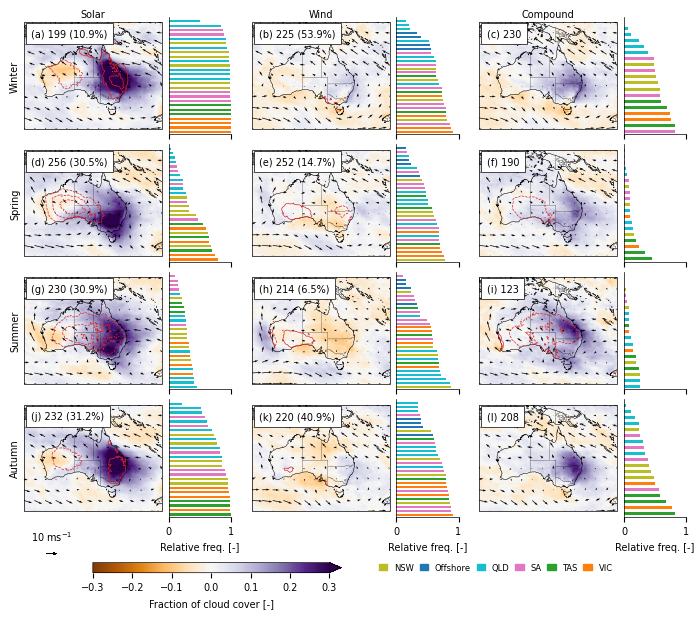

In [59]:
plot_synoptics(
    daily_plot_tcc_t2m_anoms,
    'Fraction of cloud cover [-]',
    np.arange(-0.3, 0.31, 0.1),
    'max',
    daily_plot_u_v,
    anoms=True,
    save_fig=True
)

### PDFs of city temperatures during normal versus drought days

In [145]:
def hist_t_plot(ax, season, city):
    """
    Plot histograms of temperature for a season,
    and on solar, wind or compound days (also in that season).
    """
    if season == 'Winter':
        tmin = -5
        tmax = 25
    elif (season == 'Spring') | (season == 'Autumn'):
        tmin = 0
        tmax = 30
    else:
        tmin = 5
        tmax = 35
    
    fill_alpha = 0.3

    months = season_dict[season]
    b = np.linspace(tmin, tmax, len(range(tmin, tmax)) + 1)
    bins, hist = fn.hist_data(fn.month_subset(gcc_t.sel(region=city), months), b)
    p_clim = ax.plot(bins, hist, color='k', lw=0.8, alpha=0.8, zorder=0, label='All')
    # ax.fill_between(bins, 0, hist, color='k', alpha=fill_alpha - 0.1)

    for var_name, var, color in zip(
        ['Solar', 'Wind', 'Compound'],
        [simul_mssrd, simul_100w, simul_100w_mssrd],
        [colors[1], colors[0], colors[4]]
        # [simul_100w_mssrd],
        # [colors[4]]
    ):
        _, _, _, d = subset_on_events(var, gcc_t.sel(region=city), season, thresh_spatial)

        bins, hist = fn.hist_data(d, b)
        # ax.plot(bins, hist, color=color, lw=0.8, alpha=1)
        ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha, zorder=1, label=var_name)
        
        ax.axvline(16, ls='--', lw=0.5, color=colors[0])
        ax.axvline(21, ls='--', lw=0.5, color=colors[3])
        
        ax.set_ylim(-0.015, 0.3)
        ax.set_yticks([0, 0.15, 0.3])
        
        ax.set_xticks(np.arange(tmin, tmax+1, 10))
        
        ax.legend()

In [146]:
city_names = {
    'SYD': 'Sydney',
    'MLB': 'Melbourne',
    'BNE': 'Brisbane',
    'ADL': 'Adelaide',
    'HBA': 'Hobart',
    'ACT': 'Canberra'
}

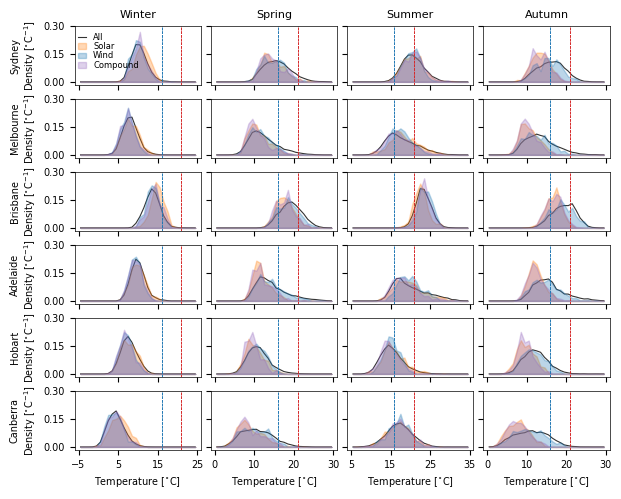

In [147]:
with plt.rc_context(plt_params):
    
    fig, axes = plt.subplots(6, 4, figsize=(6.9, 5.5))
    
    for j, season in enumerate(list(season_dict.keys())[1:]):
        for i, city in enumerate(gcc_t['region'].values):
        
            hist_t_plot(axes[i,j], season, city)
            
            if i == 0:
                axes[i,j].set_title(season)
                
            if i < 5:
                axes[i,j].set_xticklabels('')
            else:
                axes[i,j].set_xlabel(r'Temperature [$^{\circ}$C]')
            if j > 0:
                axes[i,j].set_yticklabels('')
            else:
                axes[i,j].set_ylabel(city_names[city] + '\n'+r'Density [$^{\circ}$C$^{-1}$]')
                
            if (i == 0) & (j == 0):
                axes[i,j].legend(loc=(0., 0.2), frameon=False)
            else:
                axes[i,j].legend().set_visible(False)
                
    plt.subplots_adjust(hspace=0.25, wspace=0.08)
    
    plt.savefig('./figures/FigY_temperature_pdfs.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Monthly diagnostics on spatially extensive wind/solar/compound drought years

### Set variables

In [25]:
thresh_spatial = 0.9

### Composite maps

In [32]:
def plot_sst_mslp(ax, sst_da, mslp_da, years, text=None):
    """
    Plot SST shading and MSLP contours on an axis.
    """
    m = 5000
    mslp_levels = np.arange(-m, m+1, 100)
    mslp_levels = [i for i in mslp_levels if i != 0]
    
    ax.set_extent([0, 359.99, 20, -90])
    ax.coastlines(linewidths=0.3, rasterized=True)
    
    p = sst_da.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=-1.8,
        vmax=1.8,
        cmap='RdBu_r',
        add_colorbar=False,
        rasterized=True
    )
    mslp_da.plot.contour(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=mslp_levels,
        colors='k',
        linewidths=0.3
    )
    
    if isinstance(text, str):
        ax.text(0.93, 0.93, text, ha='right', va='top',
                bbox=dict(facecolor='white', alpha=1, lw=0.5),
                transform=ax.transAxes)
    
    format_years = [str(i) for i in years]
    title = ', '.join(format_years)
    ax.set_title(title, fontsize=plt_params['font.size'] / 1.7, pad=0)
    
    return p

Task exception was never retrieved
future: <Task finished name='Task-166633' coro=<Client._gather.<locals>.wait() done, defined at /g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit


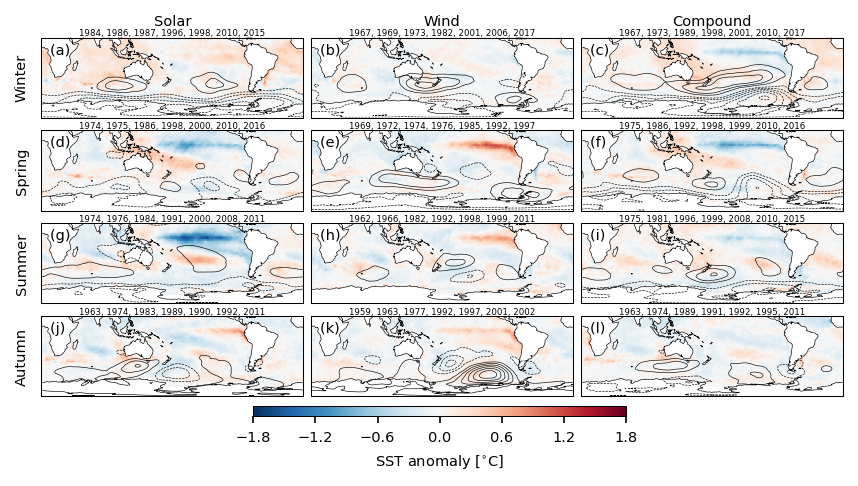

In [75]:
with plt.rc_context(plt_params):
    fig = plt.figure(figsize=(6.9, 3.2), dpi=150)
    
    axes = []
    for i in range(12):
        axes.append(fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180)))
    
    i = 0
    for season in list(season_dict.keys())[1:]:
        for var in [season_mssrd, season_100w, season_100w_mssrd]:
            years, n_events, p_sst = composite_data(
                var,
                sst_anoms['sst_anom'],
                season,
                thresh_spatial
            )

            _, _, p_mslp = composite_data(
                var,
                mslp_anoms['mslp_anom'],
                season,
                thresh_spatial
            )

            ax = axes[i]
            p = plot_sst_mslp(ax, p_sst, p_mslp, years)
            label = '(' + letters[i] + ') '
            ax.text(0.035, 0.8, label, transform=ax.transAxes)
            
            i += 1
                        
    plt.subplots_adjust(hspace=0.02, wspace=0.03)
    
    axes[0].text(0.5, 1.15, 'Solar', ha='center', transform=axes[0].transAxes)
    axes[1].text(0.5, 1.15, 'Wind', ha='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 1.15, 'Compound', ha='center', transform=axes[2].transAxes)
    
    axes[0].text(-0.1, 0.5, 'Winter', rotation=90, va='center', transform=axes[0].transAxes)
    axes[3].text(-0.1, 0.5, 'Spring', rotation=90, va='center', transform=axes[3].transAxes)
    axes[6].text(-0.1, 0.5, 'Summer', rotation=90, va='center', transform=axes[6].transAxes)
    axes[9].text(-0.1, 0.5, 'Autumn', rotation=90, va='center', transform=axes[9].transAxes)
    
    cb_ax1 = fig.add_axes([0.33, 0.08, 0.36, 0.02])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='horizontal', ticks=np.arange(-1.8, 1.9, 0.6))
    cb1.ax.set_xlabel(r'SST anomaly [$^{\circ}$C]')
    
    plt.savefig('./figures/Fig3_composites.pdf', format='pdf', dpi=400, bbox_inches='tight')

### Climate modes PDFS

In [33]:
def mode_hist(ax, event_da_list, diag_da, season, q, xmin=-2.5, xmax=2.5, nbins=20, time_name='time'):
    """
    Get the histogram of diag_da for the season, and the individual
    points for values of diag_da on event years for each event in
    event_da_list.
    """
    event_values = []
    # Loop through event_da_list (usually wind, solar and compound) to get mode index
    #  values on events.
    for i, event_da in enumerate(event_da_list):
        years, events, _, diag_events = subset_on_events(event_da, diag_da, season, q, time_name)
        event_values.append(diag_events.where(events.notnull()).dropna(time_name).values)
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])

    # Histogram
    b = np.linspace(xmin, xmax, nbins)
    bins, hist = fn.hist_data(diag_season, b)
    
    ax.plot(bins, hist, color='k', lw=0.5)
    ax.fill_between(bins, 0, hist, color='k', alpha=0.15)
    
    # +- x * standard deviations
    std = diag_season.std(time_name).values
    ax.axvline(std * 1, ls='--', lw=0.5, color='k')
    ax.axvline(std * -1, ls='--', lw=0.5, color='k')
    
    # Get ymax rounded up
    ymax = fn.round_decimals_up(np.max(hist), 1)
    # Use this to set y location of markers
    central_y = ymax / 9
    lower_y = central_y / 2.3
    upper_y = central_y * 1.8
    
    for values, y, marker, color, label in zip(
        event_values,
        [lower_y, central_y, upper_y],
        ['*', 'x', '.'],
        [colors[1], colors[0], colors[4]],
        ['Solar', 'Wind', 'Compound']
    ):
        s = ax.scatter(values, np.repeat(y, len(values)), color=color, marker=marker, s=10, lw=0.5, label=label)
        
    ax.set_xlim(xmin, xmax)
    
    # yticks (surely a better way exists...)
    if ymax > 1:
        ax.set_yticks(np.arange(0, 1.9, 0.6))
    elif (ymax <= 1) & (ymax > 0.8):
        ax.set_yticks(np.arange(0, 1.1, 0.5))
    elif (ymax <= 0.8) & (ymax > 0.5):
        ax.set_yticks(np.arange(0, 0.81, 0.4))
    else:
        ax.set_yticks(np.arange(0, 0.5, 0.2))
        
    return s

#### Print some stats

In [54]:
e_da = season_100w_mssrd
m_da = sam['sam']
season = 'Winter'

# for i, event_da in enumerate(event_da_list):
years, events, _, diag_events = subset_on_events(e_da, m_da, season, thresh_spatial, 'time')
print(diag_events.where(events.notnull()).dropna('time').values)
print(years)

[0.6771739  0.6789265  1.4623736  3.3980808  0.72280353 3.39836
 1.6517311 ]
[1967 1973 1989 1998 2001 2010 2017]


In [55]:
e_da = season_mssrd
m_da = nino34['nino34']
season = 'Summer'

# for i, event_da in enumerate(event_da_list):
years, events, _, diag_events = subset_on_events(e_da, m_da, season, thresh_spatial, 'time')
print(diag_events.where(events.notnull()).dropna('time').values)
print(years)

[-1.8821317  -1.4832062  -0.7339161   0.39295626 -1.6008415  -1.6774222
 -1.5080743 ]
[1974 1976 1984 1991 2000 2008 2011]


# Difference in drought prob between +ve and -ve phase of modes

Compute lull frequency during +ve phase years, subtract lull frequency during -ve phase years, plot map.

In [26]:
def seasonal_sum(da, time_name='time'):
    """
    Calculate seasonal sums. Currently assumes da starts in January.
    First aggregates to monthly, then shifts everything forwards
    one month, then aggregates over 3 months.
    """
    first_month = da[time_name].dt.month.values[0]
    if first_month != 1:
        raise ValueError("First month should be January. Adjust da or function.")
        
    # First aggregate to monthly as we want to shift a month ahead
    m_da = da.resample({time_name: '1MS'}).sum()
    # Now shift a month ahead and calculate 3-monthly means
    return m_da.shift({time_name: 1}).resample({time_name: '3MS'}).sum(skipna=False)

In [27]:
def subset_by_phase(event_da, diag_da, season, time_name='time'):
    """
    Subset an events dataArray by positive and negative phases of climate modes.
    
    event_da: DataArray of daily events
    diag_da: mode DataArray
    season: season of interest
    """
    # diag_da subset by season
    diag_season = fn.month_subset(diag_da, fn.get_seasons()[season])
    # +- x standard deviation thresholds
    std = diag_season.std(time_name).values
    low_thresh = std * -1
    high_thresh = std * 1
    
    # Events subset by diag_season
    low_events = event_da.where(diag_season < low_thresh)
    high_events = event_da.where(diag_season > high_thresh)
    
    return low_events, high_events

In [28]:
def event_diff(event_da, diag_da, season, scale=None, time_name='time'):
    """
    Difference in number of events, computed as event frequency during
    positive mode phases minus event frequency during negative mode phases.
    
    Can be scaled by the standard deviation to say e.g. wind droughts during
    positive ENSO are more frequent on average that during negative ENSO by
    2 standard deviations.
    """
    # Subset events by negative and positive phases of mode
    neg, pos = subset_by_phase(event_da, diag_da, season, time_name)
    
    neg_m = neg.mean(time_name)
    pos_m = pos.mean(time_name)
    diff = (pos_m - neg_m)
    
    if scale == 'std':
        return  diff / event_da.std(time_name)
    else:
        return diff

First get gridded events

In [29]:
aus_events_mssrd = fn.get_events(aus_mssrd, thresh_mssrd, tail='lower')
aus_events_100w = fn.get_events(aus_100w, thresh_100w, tail='lower')
aus_events_100w_mssrd = fn.get_compound_events(aus_100w, aus_mssrd, thresh_100w, thresh_mssrd)

Now get the seasonal totals

In [30]:
# aus_events_mssrd_seasonal = fn.seasonal_mean(aus_events_mssrd).compute()
# aus_events_100w_seasonal = fn.seasonal_mean(aus_events_100w).compute()
# aus_events_both_seasonal = fn.seasonal_mean(aus_events_100w_mssrd).compute()

In [33]:
aus_events_mssrd_seasonal_total = seasonal_sum(aus_events_mssrd).compute()
aus_events_100w_seasonal_total = seasonal_sum(aus_events_100w).compute()
aus_events_both_seasonal_total = seasonal_sum(aus_events_100w_mssrd).compute()

### Bootstrapping (as of 15/06/23)

We want to:
- Draw a bootstrap sample of seasons equal in length to the observations
- From this sample, randomly select two sets of seasons, equal in length to the number of seasons above and below the thresholds for +ve and -ve climate mode phases.
- Subtract these from each other.
- Repeat 10000 times
- Compare obs with this 10,000-size sample


In [34]:
def estimate_L(da):
    """
    Estimates block length L for each grid box of da.
    """
    from statsmodels.tsa.stattools import acf
    
    def acf_lag1(x):
        if np.sum(~np.isnan(x)) == 0: # if all NaNs
            return np.nan
        else:
            x = x[~np.isnan(x)]
            return acf(x, nlags=1)[-1]
    
    n = len(da.time.values)
    
    # DataArray of lag1 ACF coefficients
    rho_da = xr.apply_ufunc(
        acf_lag1,
        da,
        input_core_dims=[['time']],
        output_core_dims=[[]],
        vectorize=True,
        dask='forbidden'
    )
    
    # DataArray of effective sample size
    n_eff_da = n * ((1 - rho_da) / (1 + rho_da))
    
    # Initialise guess for block length
    Ls_da = xr.full_like(rho_da, 1)
    for i in range(10): # iterate to get estimate of L
        L_da = (n - Ls_da + 1) ** ( (2/3) * (1 - n_eff_da / n) )
        Ls_da = L_da
    
    return np.ceil(L_da) # round up to get block length

In [35]:
def get_quantile(obs, bootstrap):
    """
    Returns the quantile of obs in bootstrap
    
    obs: float or int
    bootstrap: array
    """
    if np.isnan(obs):
        return np.nan
    else:
        return np.searchsorted(np.sort(bootstrap), obs) / len(bootstrap)
        # return dask.array.searchsorted(np.sort(bootstrap), obs) / len(bootstrap)

In [36]:
def apply_quantile(obs_da, bootstrap_da, absolute=False, lat_name="lat", lon_name="lon"):
    """
    Gets the quantiles of obs_da in bootsrap_da.
    
    obs_da: array of observations
    bootstrap_da: array of bootstrap samples
    absolute: whether to compute the quantile on absolute values
    lat_name, lon_name: names of these dims
    """
    # need lats in ascending order: https://stackoverflow.com/a/53175095
    obs_da = obs_da.sortby(lat_name, ascending=True)
    bootstrap_da = bootstrap_da.sortby(lat_name, ascending=True)
    
    if absolute: # for e.g. magnitude of change, we want the quantile of the absolute change
        obs_da = np.abs(obs_da)
        bs_da = np.abs(bootstrap_da)
        
    # stack lat and lon onto new dimension 'point', then group by point
    obs_stack = obs_da.stack(point=(lat_name, lon_name)).groupby('point')
    bs_stack = bootstrap_da.stack(point=(lat_name, lon_name)).groupby('point')
    
    quantiles = xr.apply_ufunc(
        get_quantile,
        obs_stack,
        bs_stack,
        input_core_dims=[[], ['iteration']],
        output_core_dims=[[]],
        dask='allowed'
    )
    # unstack and sort lats to original ordering
    ds = quantiles.unstack('point').sortby(lat_name, ascending=False)
    
    return ds

In [37]:
def stat_signif_diff(
    obs_da,
    event_da,
    mode_da,
    season,
    block_lengths,
    n_iter=10,
    lower_q=0.05,
    upper_q=0.95
):
    """
    Compute statistical significance for difference in number of drought
    days between positive and negative mode phases.
    
    This function takes a random sample of seasons of equal size to event_da,
    sampled in sizes of block_lengths.
    Then, it takes two further subsamples of equal size to the number seasons
    that are below (mean - stan. dev.), and above (mean + stan. dev.) of mode_da.
    Then, these two subsamples are subtracted from each other. Repeat n_iter times.
    Compute lower_q and upper_q quantiles of these bootstrap samples, and assign
    significance if event_da lies outside these quantiles.
    
    obs_da: array to compare resamples to
    event_da: array to resample
    mode_da: array used to obtain subsample sizes
    season: season to process
    block_lengths: list or array of block lengths
    n_iter: number of iterations
    lower_q, upper_q: [0,1], quantiles to assign significance
    """
    # Season for event_da and obs_da
    months = fn.get_seasons()[season]
    event_da = fn.month_subset(event_da, months)
    # obs_da = fn.month_subset(obs_da, months)
    
    # Sample sizes of subsamples (from climate mode series)
    mode = fn.month_subset(mode_da, months)
    n_neg = mode.where(mode < -1 * mode.std("time")).count().values
    n_pos = mode.where(mode > mode.std("time")).count().values
    # print(n_neg, n_pos)
    
    pvals_list = []
    # For each block length
    for L in block_lengths:
        # Obtain bootstrap samples
        bootstraps = block_bootstrap(
            event_da,
            blocks={'time': L},
            n_iteration=n_iter,
            exclude_dims=None,
            circular=True
        )
        bootstraps = bootstraps.assign_coords({"iteration": range(n_iter)})
    
        # Get random indices of years equal in size to mode phases
        n = len(event_da.time)
        rand1 = np.random.randint(low=0, high=n, size=n_pos)
        rand2 = np.random.randint(low=0, high=n, size=n_neg)

        # Average over these random years and take difference
        bootstrap_pos = bootstraps.isel(time=rand1).mean('time')
        bootstrap_neg = bootstraps.isel(time=rand2).mean('time')
        bootstrap_diff = bootstrap_pos - bootstrap_neg
        
        # Compute p-values of observations
        # First need quantiles of obs relative to bootstrap
        q_obs = apply_quantile(obs_da, bootstrap_diff)
        # p-values: different formula depending on upper or lower tail
        # p = q, if q < 0.5,
        # p = 1 - q, if q > 0.5
        pvals = q_obs.where(q_obs <= 0.5, 1 - q_obs)

        pvals_list.append(q_obs.assign_coords({'L': L}))

    return xr.concat(pvals_list, dim="L")

In [38]:
def fdr(p_values_da, alpha=0.1):
    """
    Calculates significance on a DataArray of gridded p-values (p_values_da)
    by controlling the false discovery rate.
    Returns a DataArray of ones (significant) and zeros (not significant).
    
    p_values_da: array of p-values
    alpha: significance level (often double the alpha in standard hypothesis test)
    """
    p_1d = p_values_da.values.reshape(-1) # 1-D array of p-values
    p_1d = p_1d[~np.isnan(p_1d)] # Remove NaNs
    sorted_pvals = np.sort(p_1d) # sort p-values
    N = len(sorted_pvals) # sample size
    
    fdr_criteria = alpha * (np.arange(1, N+1) / N) # the diagonal line of criteria
    pvals_less_than_fdr_criteria = np.where(sorted_pvals < fdr_criteria)[0]
    
    if len(pvals_less_than_fdr_criteria) > 0: #if any p-values satisfy the FDR criteria
        # index of the largest p-value still under the fdr_criteria line.
        largest_p_less_than_criteria = pvals_less_than_fdr_criteria[-1]
        # the p-value for controlling the FDR
        p_fdr = sorted_pvals[largest_p_less_than_criteria] 
    else:
        p_fdr = -1 # abritrary number < 0. Ensures no significant results.
    
    # massage data into binary indicators of FDR significance
    keep_signif = p_values_da.where(p_values_da <= p_fdr, -999)
    signif_da = keep_signif.where(keep_signif == -999, 1)
    signif_da = signif_da.where(signif_da == 1, 0)
    return signif_da.where(p_values_da.notnull(), np.nan)

In [ ]:
%%time

import pickle
import regionmask

fp = "/g/data/w42/dr6273/work/projects/Aus_energy/data/"

for season in ["Winter", "Spring", "Summer", "Autumn"]:
    print(season)
    months = fn.get_seasons()[season]
    
    for event_type, event_da in zip(
        ["Solar", "Wind", "Compound"],
        [aus_events_mssrd_seasonal_total, aus_events_100w_seasonal_total, aus_events_both_seasonal_total]
    ):
        print(event_type)
        
        season_da = fn.month_subset(aus_events_both_seasonal_total, months)
                
        mask = regionmask.defined_regions.natural_earth.countries_110.mask(
            season_da.lon,
            season_da.lat[3:]
        )
        
        # Estimate autocorrelation for block length
        L = estimate_L(season_da).astype('int')
        unique_block_lengths = range(1, L.max().values+1)
        # print(unique_block_lengths)
        
        for mode_name, mode_da in zip(
            ["ENSO", "IOD", "SAM"],
            [nino34["nino34"], dmi["dmi"], sam["sam"]]
        ):  
            print(mode_name)
            
            obs_ = event_diff(season_da, mode_da, season).compute()
            to_resample_ = season_da.compute()
            
            pvals = stat_signif_diff(
                obs_,
                to_resample_,
                mode_da,
                season,
                unique_block_lengths,
                n_iter=1000
            )
         
            print("pickling...")
            with open(
                fp+"mode_phase_drought_diff_fdr_"+season+"_"+event_type+"_"+mode_name+"_1000_reps.pickle",
                'wb'
            ) as handle:
                pickle.dump(pvals, handle, protocol=pickle.HIGHEST_PROTOCOL)

Winter
Solar


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Wind


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Compound


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Spring
Solar


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Wind


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Compound


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Summer
Solar


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Wind


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Compound


/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


ENSO
pickling...
IOD
pickling...
SAM
pickling...
Autumn
Solar
ENSO


In [188]:
with open(
    fp+"mode_phase_drought_diff_fdr_"+season+".pickle",
    'rb'
) as handle:
    a = pickle.load(handle)

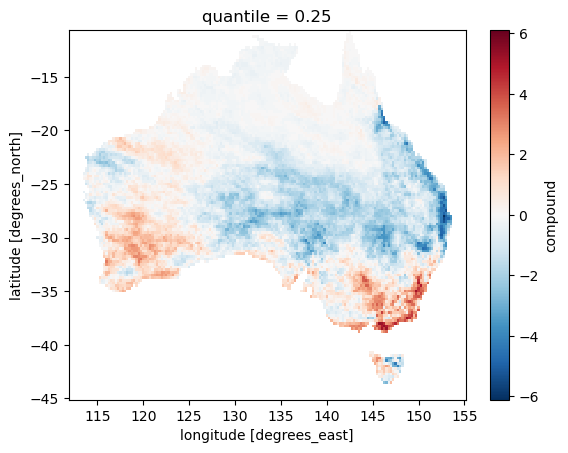

In [149]:
obs_.compute().where(mask.notnull()).plot()

In [151]:
%%time
pvals = stat_signif_diff(
    obs_.compute().where(mask.notnull()),
    da.compute().where(mask.notnull()),
    nino34["nino34"],
    "Winter",
    [1],
    n_iter=1000
)

9 9
CPU times: user 2min 15s, sys: 3min 28s, total: 5min 44s
Wall time: 5min 18s


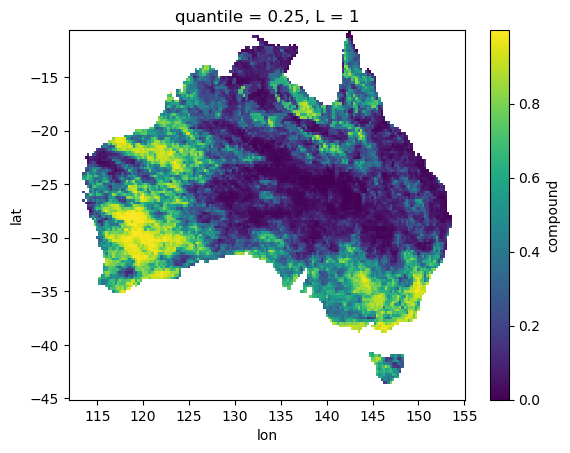

In [152]:
pvals.sel(L=1).plot()

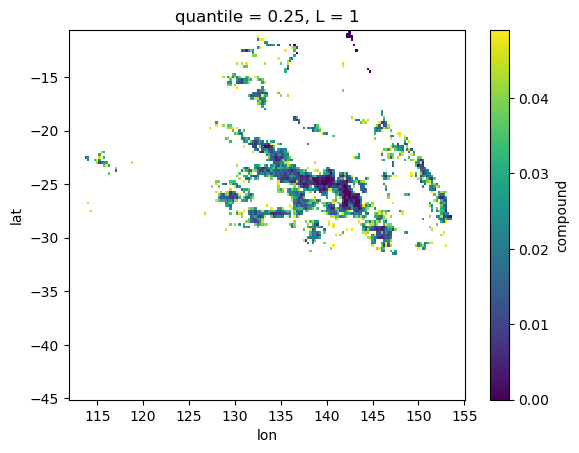

In [155]:
pvals.where(pvals<0.05).sel(L=1).plot()

In [165]:
pval_fdr = fdr(pvals)

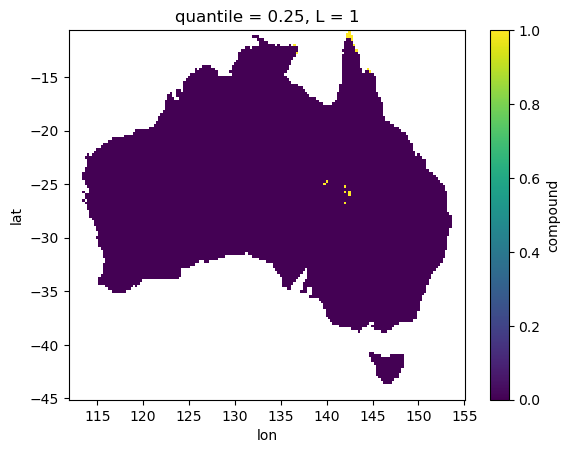

In [166]:
pval_fdr.plot()

In [167]:
from cartopy.util import add_cyclic_point

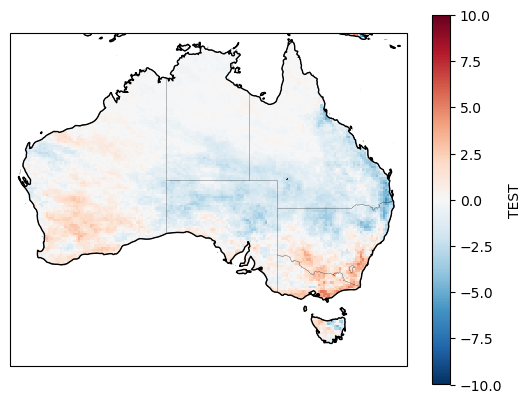

In [168]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})

plot_mode_diff(
    ax,
    aus_events_both_seasonal_total,
    nino34["nino34"],
    "Winter",
    None,
    -10,
    10,
    'TEST'
)
ax.coastlines(zorder=5)

fdr_da = xr.where(pval_fdr.sel(L=1) == 1, 1, np.nan).values
cyclic_fdr, cyclic_lon = add_cyclic_point(fdr_da, coord=pval_fdr.lon)
ax.pcolor(cyclic_lon, pval_fdr.lat, cyclic_fdr,
          hatch='///', shading='auto', alpha=0, rasterized=False,
         zorder=5)


In [158]:
def plot_mode_diff(ax, event_da, mode_da, season, scale, vmin, vmax, label):
    """
    Plot difference in mean event frequency between positive
    and negative phases of a climate mode.
    """
    ax.set_extent([112, 155, -10, -44])
    ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.1,
        rasterized=True
    )
    ax.add_feature(
        cartopy.feature.OCEAN, facecolor='white', zorder=1, rasterized=True
    )
    ax.coastlines(lw=.3, rasterized=True, zorder=2)
    
    diff = event_diff(event_da, mode_da, season, scale)
        
    # Set cmap limits and ensure cbar extends correctly
    p_min = diff.min().values
    p_max = diff.max().values
    
    if (p_min < vmin) & (p_max <= vmax):
        cbar_extend = 'min'
    elif (p_min < vmin) & (p_max > vmax):
        cbar_extend = 'both'
    elif (p_min >= vmin) & (p_max <= vmax):
        cbar_extend = 'neither'
    elif (p_min >= vmin) * (p_max > vmax):
        cbar_extend = 'max'
    else:
        raise ValueError('Something weird happening with vmin/vmax')
        
    cbar_kwargs = {'extend': cbar_extend, 'label': label}
    
    diff.plot(cmap='RdBu_r', vmin=vmin, vmax=vmax, cbar_kwargs=cbar_kwargs, rasterized=True, zorder=0)
    ax.set_title('')

# Fig of mode hists and mode-phase event differences

In [70]:
def fig_mode_pdf_and_diff(
    mode_xmins, events_list, season, scale, dividers, cbar_label='Number of\nevents [days]', save_fig=False
):
    """
    Plot mode PDFs and diff maps for this season.
    """
    with plt.rc_context(plt_params):
        fig = plt.figure(dpi=100, figsize=(6, 5.5)) 
    
        # ===================== Mode PDFs
        mode_list = [nino34['nino34'], dmi['dmi'], sam['sam']]
        mode_names = ['ENSO', 'IOD', 'SAM']
        xlabels = [r'Ni$\mathrm{\tilde{n}}$o3.4 [$^{\circ}$C]',
                   r'DMI [$^{\circ}$C]',
                   'SAM index [-]']
        xmins = mode_xmins
        xmaxs = [-1 * i for i in xmins]
        
        # gs = fig.add_gridspec(nrows=1, ncols=3, left=0, right=1, bottom=0.85, top=1)
                
        count = 0
        for i, (mode, name, xlabel, xmin, xmax) in enumerate(zip(
            mode_list,
            mode_names,
            xlabels,
            xmins,
            xmaxs
        )):
            gs = fig.add_gridspec(nrows=1, ncols=1,
                                  left=0.0 + (0.35 * i), right=0.25 + (0.35 * i),
                                  bottom=0.85, top=1)
            ax = plt.subplot(gs[0])
            s = mode_hist(
                ax,
                [season_mssrd, season_100w, season_100w_mssrd],
                mode,
                season,
                thresh_spatial,
                xmin,
                xmax,
                nbins=15
            )
            label = '(' + letters[count] + ') '
            ax.text(0.035, 0.85, label, transform=ax.transAxes)
            ax.set_title(name)
            ax.set_xlabel(xlabel)
            if i == 2:
                ax.set_ylabel('Density [-]')
                ax.legend(loc=(1.01, 0), frameon=False)
            else:
                ax.set_ylabel(r'Density [$^{\circ}$C$^{-1}$]')

            count += 1
        # =================== Difference plots
        for i, (name, event_da, divider) in enumerate(zip(
            ['Solar', 'Wind', 'Compound'],
            events_list,
            dividers,
        )):
            gs = fig.add_gridspec(nrows=1, ncols=3, left=0, right=1, bottom=0.5 - (0.25 * i), top=0.73 - (0.25 * i))
            
            for j, (mode_da, title) in enumerate(zip(
                mode_list,
                [r'ENSO$^{+} - $ENSO$^{-}$', r'IOD$^{+} - $IOD$^{-}$', r'SAM$^{+} - $SAM$^{-}$']
            )):
                if count in [5, 8, 11]:
                    label = cbar_label
                else:
                    label = ''

                ax = plt.subplot(gs[j], projection=ccrs.PlateCarree())
                ax.text(0.03, 0.9, '(' + letters[count] + ')', transform=ax.transAxes)
                
                vmin_scaled = -10 / divider
                vmax_scaled = 10 / divider
                    
                plot_mode_diff(ax, event_da, mode_da, season, scale, vmin_scaled, vmax_scaled, label)
            
                if j == 0:
                    ax.text(-0.15, 0.5, name, rotation=90, va='center', transform=ax.transAxes)

                if i == 0:
                    ax.set_title(title)
                    
                count += 1
                
        if save_fig:
            plt.savefig('./figures/Fig4_modes_'+season+'.pdf', format='pdf', dpi=400, bbox_inches='tight')

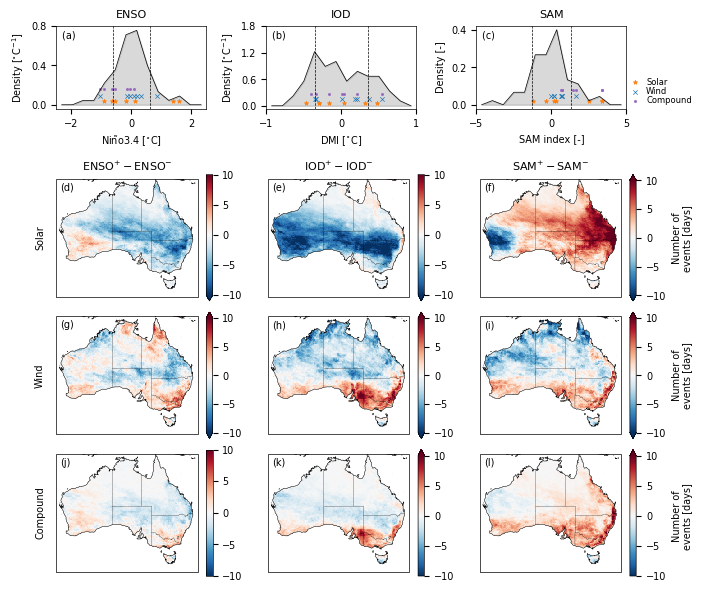

In [72]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Winter', scale=None, dividers=[1, 1, 1], save_fig=True)

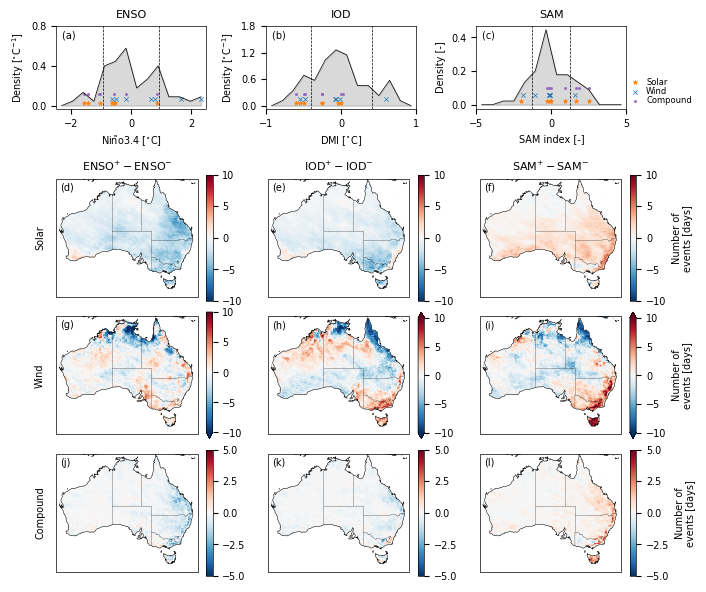

In [73]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Spring', scale=None, dividers=[1, 1, 2], save_fig=True)

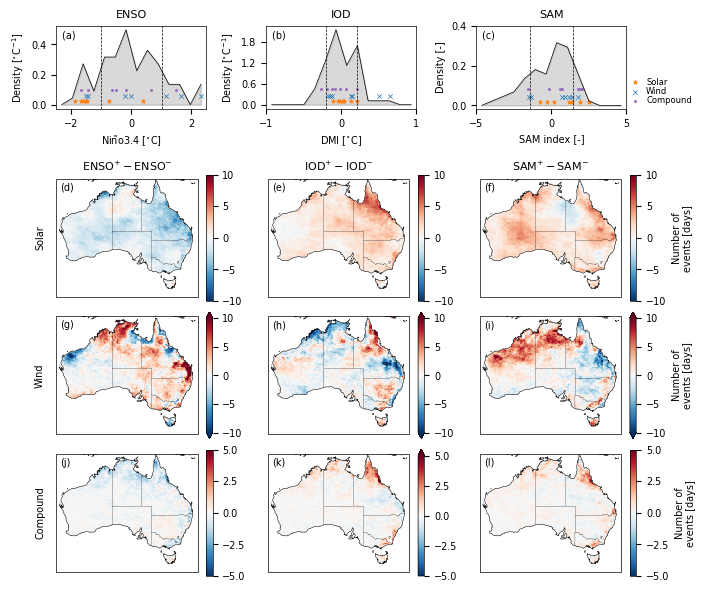

In [74]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Summer', scale=None, dividers=[1, 1, 2], save_fig=True)

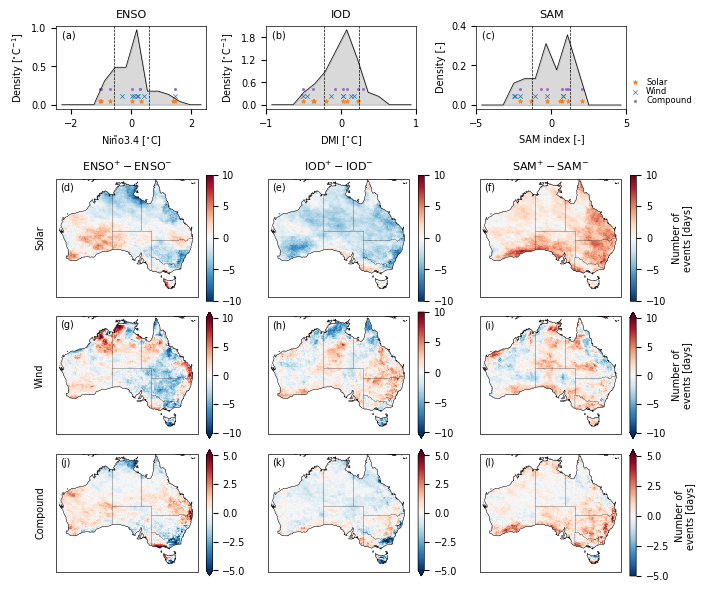

In [75]:
fig_mode_pdf_and_diff(
    [-2.5, -1, -5],
    [
    aus_events_mssrd_seasonal_total,
    aus_events_100w_seasonal_total,
    aus_events_both_seasonal_total
], 'Autumn', scale=None, dividers=[1, 1, 2], save_fig=True)

# Close cluster

In [55]:
client.close()
cluster.close()